This can be run [run on Google Colab using this link](https://colab.research.google.com/github/CS7150/CS7150-Homework_3/blob/main/HW3.1-Classifiers.ipynb)

## MNIST Classifiers (Convolutional Neural Networks and Fully Connected Networks)

<b>Optional</b>: Installing Wandb to see cool analysis of you code. You can go through the documentation here. We will do it for this assignment to get a taste of the GPU and CPU utilizations. If this is creating problems to your code, please comment out all the wandb lines from the notebook 

In [3]:
# Uncomment the below line to install wandb (optinal)
!pip install wandb 
# Uncomment the below line to install torchinfo (https://github.com/TylerYep/torchinfo) [Mandatory]
!pip install torchinfo

In [4]:
%%bash

wget -N https://cs7150.baulab.info/2022-Fall/data/mnist-classify.pth

--2023-10-20 16:11:23--  https://cs7150.baulab.info/2022-Fall/data/mnist-classify.pth


Resolving cs7150.baulab.info (cs7150.baulab.info)... 35.232.255.106
Connecting to cs7150.baulab.info (cs7150.baulab.info)|35.232.255.106|:443... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘mnist-classify.pth’ not modified on server. Omitting download.



In [5]:
# Importing libraries
import matplotlib.pyplot as plt
import torch 
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split,Subset
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torchinfo import summary
import numpy as np
import datetime
import os
from typing import List
from collections import OrderedDict
import math

In [6]:

import torch
if torch.backends.mps.is_available():
    device = torch.device("mps")
    x = torch.ones(1, device=device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


In [6]:
# Create an account at https://wandb.ai/site and paste the api key here (optional)
# WANDB_API_KEY = 'd1792e5f11bc4b7d9e6b9ea26ea7a213270a7b67'
import wandb
os.environ["WANDB_API_KEY"] ='d1792e5f11bc4b7d9e6b9ea26ea7a213270a7b67'
wandb.init(project="hw3.1-ConvNets")


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: karan-mudaliar1999 (karan_mudaliar). Use `wandb login --relogin` to force relogin


### Some helper functions to view network parameters

In [7]:
def view_network_parameters(model):
    # Visualise the number of parameters
    tensor_list = list(model.state_dict().items())
    total_parameters = 0
    print('Model Summary\n')
    for layer_tensor_name, tensor in tensor_list:
        total_parameters += int(torch.numel(tensor))
        print('{}: {} elements'.format(layer_tensor_name, torch.numel(tensor)))
    print(f'\nTotal Trainable Parameters: {total_parameters}!')

In [8]:
def view_network_shapes(model, input_shape):
    print(summary(conv_net, input_size=input_shape))

### Fully Connected Network for Image Classification
Let's build a simple fully connected network!

In [9]:
def simple_fc_net():
    model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(1*28*28,8*28*28),
        nn.ReLU(),
        nn.Linear(8*28*28,16*14*14),
        nn.ReLU(),
        nn.Linear(16*14*14,32*7*7),
        nn.ReLU(),
        nn.Linear(32*7*7,288),
        nn.ReLU(),
        nn.Linear(288,64),
        nn.ReLU(),
        nn.Linear(64,10),
        nn.LogSoftmax())
    return model

In [10]:
fc_net = simple_fc_net()

In [11]:
view_network_parameters(fc_net)

Model Summary

1.weight: 4917248 elements
1.bias: 6272 elements
3.weight: 19668992 elements
3.bias: 3136 elements
5.weight: 4917248 elements
5.bias: 1568 elements
7.weight: 451584 elements
7.bias: 288 elements
9.weight: 18432 elements
9.bias: 64 elements
11.weight: 640 elements
11.bias: 10 elements

Total Trainable Parameters: 29985482!


In [12]:
from torchinfo import summary
summary(fc_net, input_size=(1, 1, 28,28))

/Users/karan_mudaliar/miniconda3/lib/python3.11/site-packages/torch/nn/modules/module.py:1519: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Flatten: 1-1                           [1, 784]                  --
├─Linear: 1-2                            [1, 6272]                 4,923,520
├─ReLU: 1-3                              [1, 6272]                 --
├─Linear: 1-4                            [1, 3136]                 19,672,128
├─ReLU: 1-5                              [1, 3136]                 --
├─Linear: 1-6                            [1, 1568]                 4,918,816
├─ReLU: 1-7                              [1, 1568]                 --
├─Linear: 1-8                            [1, 288]                  451,872
├─ReLU: 1-9                              [1, 288]                  --
├─Linear: 1-10                           [1, 64]                   18,496
├─ReLU: 1-11                             [1, 64]                   --
├─Linear: 1-12                           [1, 10]      

<b>Exercise</b>: Now try to add different layers and see how the network parameters vary. Does adding layers reduce the parameters? Does the number of hidden neurons in the layers affect the total trainable parameters? 

<i>Add a few sentences on your observations while using various architectures</i>

In [13]:
#OBSERVATIONS ARE BELOW, DIFFERENT ARCHITERCTURES IN THIS CELL

def simple_fc_net_deeper():
    model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(1*28*28,8*28*28),
        nn.ReLU(),
        nn.Linear(8*28*28,16*14*14),
        nn.ReLU(),
        nn.Linear(16*14*14,16*14*14),
        nn.ReLU(),
        nn.Linear(16*14*14,16*14*14),
        nn.ReLU(),
        nn.Linear(16*14*14,32*7*7),
        nn.ReLU(),
        nn.Linear(32*7*7,288),
        nn.ReLU(),
        nn.Linear(288,64),
        nn.ReLU(),
        nn.Linear(64,10),
        nn.LogSoftmax())
    return model

def simple_fc_net_wider():
    model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(1*28*28,8*28*28),
        nn.ReLU(),
        nn.Linear(8*28*28,16*64*64),
        nn.ReLU(),
        nn.Linear(16*64*64,32*7*7),
        nn.ReLU(),
        nn.Linear(32*7*7,288),
        nn.ReLU(),
        nn.Linear(288,64),
        nn.ReLU(),
        nn.Linear(64,10),
        nn.LogSoftmax())
    return model

In [14]:
fc_net_deeper = simple_fc_net_deeper()
fc_net_wider = simple_fc_net_wider()

In [15]:
view_network_parameters(fc_net_deeper)
view_network_parameters(fc_net_wider)

Model Summary

1.weight: 4917248 elements
1.bias: 6272 elements
3.weight: 19668992 elements
3.bias: 3136 elements
5.weight: 9834496 elements
5.bias: 3136 elements
7.weight: 9834496 elements
7.bias: 3136 elements
9.weight: 4917248 elements
9.bias: 1568 elements
11.weight: 451584 elements
11.bias: 288 elements
13.weight: 18432 elements
13.bias: 64 elements
15.weight: 640 elements
15.bias: 10 elements

Total Trainable Parameters: 49660746!
Model Summary

1.weight: 4917248 elements
1.bias: 6272 elements
3.weight: 411041792 elements
3.bias: 65536 elements
5.weight: 102760448 elements
5.bias: 1568 elements
7.weight: 451584 elements
7.bias: 288 elements
9.weight: 18432 elements
9.bias: 64 elements
11.weight: 640 elements
11.bias: 10 elements

Total Trainable Parameters: 519263882!


In [16]:
#Please type your answer here ...
### ANSWER
'''
As we can see from the above examples

Adding more layers to a fully connected increases the number of parameters, especially if the new layers have a large number of neurons. 

The number of hidden neurons in each layer directly affects the total trainable parameters, so increasing network width increases number of paramteres
'''

'\nAs we can see from the above examples\n\nAdding more layers to a fully connected increases the number of parameters, especially if the new layers have a large number of neurons. \n\nThe number of hidden neurons in each layer directly affects the total trainable parameters, so increasing network width increases number of paramteres\n'

### Convolutional Neural Network for Image Classification
Let's build a simple CNN to classify our images. 
<b> Exercise 3.1.1:</b> In the function below please add the conv/Relu/Maxpool layers to match the shape of FC-Net. Suppose at the some layer the FC-Net has `28*28*16` dimension, we want your conv_net to have `16 X 28 X 28` shape at the same numbered layer. <br>
<b>Extra-credit:</b> Try not to use MaxPool2d !

In [18]:
""" def simple_fc_net():
    model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(1*28*28,8*28*28),
        nn.ReLU(),
        nn.Linear(8*28*28,16*14*14),
        nn.ReLU(),
        nn.Linear(16*14*14,32*7*7),
        nn.ReLU(),
        nn.Linear(32*7*7,288),
        nn.ReLU(),
        nn.Linear(288,64),
        nn.ReLU(),
        nn.Linear(64,10),
        nn.LogSoftmax())
    return model
"""
### EXTRA CREDIT ### NO MAX POOLING USED IN TO DO BLOCK
def simple_conv_net():
    model = nn.Sequential(
        nn.Conv2d(1,8,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.Conv2d(8,16,kernel_size = 3, stride= 2, padding=1),
        nn.ReLU(),
        nn.Conv2d(16,32,kernel_size = 3, stride = 2, padding = 1),
        nn.ReLU(),

        # TO-DO: Add layers below
        # """
        # Add your code here to match the output shape of the FC-Net 
        # """
        # TO-DO, what will your shape be after you flatten? Fill it in place of None
        nn.Flatten(),
        nn.Linear(1568,288),
        nn.ReLU(),
        nn.Linear(288,64),
        # Do not change the code below
        nn.ReLU(),
        nn.Linear(64,10),
        nn.LogSoftmax())
    return model


In [19]:
conv_net = simple_conv_net()

In [20]:
view_network_parameters(conv_net)

Model Summary

0.weight: 72 elements
0.bias: 8 elements
2.weight: 1152 elements
2.bias: 16 elements
4.weight: 4608 elements
4.bias: 32 elements
7.weight: 451584 elements
7.bias: 288 elements
9.weight: 18432 elements
9.bias: 64 elements
11.weight: 640 elements
11.bias: 10 elements

Total Trainable Parameters: 476906!


In [20]:
view_network_shapes(conv_net, input_shape=(1,1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 8, 28, 28]            80
├─ReLU: 1-2                              [1, 8, 28, 28]            --
├─Conv2d: 1-3                            [1, 16, 14, 14]           1,168
├─ReLU: 1-4                              [1, 16, 14, 14]           --
├─Conv2d: 1-5                            [1, 32, 7, 7]             4,640
├─ReLU: 1-6                              [1, 32, 7, 7]             --
├─Flatten: 1-7                           [1, 1568]                 --
├─Linear: 1-8                            [1, 288]                  451,872
├─ReLU: 1-9                              [1, 288]                  --
├─Linear: 1-10                           [1, 64]                   18,496
├─ReLU: 1-11                             [1, 64]                   --
├─Linear: 1-12                           [1, 10]                   650

In [21]:
view_network_parameters(fc_net)

Model Summary

1.weight: 4917248 elements
1.bias: 6272 elements
3.weight: 19668992 elements
3.bias: 3136 elements
5.weight: 4917248 elements
5.bias: 1568 elements
7.weight: 451584 elements
7.bias: 288 elements
9.weight: 18432 elements
9.bias: 64 elements
11.weight: 640 elements
11.bias: 10 elements

Total Trainable Parameters: 29985482!


<b>Exercise 3.1.2</b>: Why is the final layer a log softmax? What is a softmax function? Can we use ReLU instead of softmax? If yes, what would you do different? If not, tell us why. If you think there is a different answer, feel free to use this space to chart it down

 Please type your answer here ...
 
 - log softmax function is often used in the final layer of a classification neural network because it provides a log probability for each class in a multi-class classification problem
 - softmax function is an activation function that converts a vector of raw scores (from the second last layer) into a probability distribution over multiple classes.
 - RelU cannot convert vector outputs to probabliltiy distributions. So it cannot be used for classification problems. It can maybe be used in regression predictions if we for sure know that the prediction rage is non negative but this is also up for debate


<b>Exercise 3.1.3</b>: What is the ratio of number of parameters of Conv-net to number of parameters of FC-Net <br>
$\frac{p_{conv-net}}{p_{fc-net}}$ ~ 0.1766<br>
Do you see the difference ?! 
- Yes there is a massive difference, about 83%

<b>Exercise 3.1.4</b>: Now try to add different layers and see how the network parameters vary. Does adding layers reduce the parameters? Does the number of hidden neurons in the layers affect the total trainable parameters? Use the `build_custom_fc_net` function given below. You do not have to understand the working of it. 

<i>Add a few sentences on your observations while using various architectures</i>


<b>As we can see from the above examples and below ones</b>

<b>Adding more layers to a fully connected increases the number of parameters, especially if the new layers have a large number of neurons. </b>

<b>The number of hidden neurons in each layer directly affects the total trainable parameters, so increasing network width increases number of paramteres</b>

In [21]:
def build_custom_fc_net(inp_dim: int, out_dim: int, hidden_fc_dim: List[int]):
    '''
    Inputs :
    
    inp_dim: Shape of the input dimensions (in MNIST case 28*28)
    out_dim: Desired classification classes (in MNIST case 10)
    hidden_fc_dim: List of the intermediate dimension shapes (list of integers). Try different values and see the shapes'
    
    Return: nn.Sequential (final custom model)
    '''
    assert type(hidden_fc_dim) == list, "Please define hidden_fc_dim as list of integers"
    layers = []
    layers.append((f'flatten', nn.Flatten()))
    # If no hidden layer is required
    if len(hidden_fc_dim) == 0:
        layers.append((f'linear',nn.Linear(math.prod(inp_dim),out_dim)))
        layers.append((f'activation',nn.LogSoftmax()))
    else:
        # Loop over hidden dimensions and add layers
        for idx, dim in enumerate(hidden_fc_dim):
            if idx == 0:
                layers.append((f'linear_{idx+1}',nn.Linear(math.prod(inp_dim),dim)))
                layers.append((f'activation_{idx+1}',nn.ReLU()))
            else:
                layers.append((f'linear_{idx+1}',nn.Linear(hidden_fc_dim[idx-1],dim)))
                layers.append((f'activation_{idx+1}',nn.ReLU()))
        layers.append((f'linear_{idx+2}',nn.Linear(dim,out_dim)))
        layers.append((f'activation_{idx+2}',nn.LogSoftmax()))
        
    model =  nn.Sequential(OrderedDict(layers))
    return model

# TO-DO build different networks (atleast 3) and see the parameters
#(You don't have to understand the function above. It is a generic way to build a FC-Net)


fc_net_custom1 = build_custom_fc_net(inp_dim=(1,28,28), out_dim=10, hidden_fc_dim=[128,64,32])
view_network_parameters(fc_net_custom1)

# fc_net_custom2 = 
# view_network_parameters(fc_net_custom2)

# fc_net_custom3 = 
# view_network_parameters(fc_net_custom3)

Model Summary

linear_1.weight: 100352 elements
linear_1.bias: 128 elements
linear_2.weight: 8192 elements
linear_2.bias: 64 elements
linear_3.weight: 2048 elements
linear_3.bias: 32 elements
linear_4.weight: 320 elements
linear_4.bias: 10 elements

Total Trainable Parameters: 111146!


## Let's train the models to see their performace

In [22]:
# downloading mnist into folder
data_dir = 'data' # make sure that this folder is created in your working dir
# transform the PIL images to tensor using torchvision.transform.toTensor method
train_data = torchvision.datasets.MNIST(data_dir, train=True, download=True, transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor()]))
test_data  = torchvision.datasets.MNIST(data_dir, train=False, download=True, transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor()]))
print(f'Datatype of the dataset object: {type(train_data)}')
# check the length of dataset
n_train_samples = len(train_data)
print(f'Number of samples in training data: {len(train_data)}')
print(f'Number of samples in test data: {len(test_data)}')
# Check the format of dataset
#print(f'Foramt of the dataset: \n {train_data}')

val_split = .2
batch_size=256 

train_data_, val_data = random_split(train_data, [int(n_train_samples*(1-val_split)), int(n_train_samples*val_split)])

train_loader = torch.utils.data.DataLoader(train_data_, batch_size=batch_size,shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,shuffle=True)

Datatype of the dataset object: <class 'torchvision.datasets.mnist.MNIST'>
Number of samples in training data: 60000
Number of samples in test data: 10000


### Displaying the loaded dataset

/var/folders/dn/jhd9djgd393gp0dk2lz40m2c0000gp/T/ipykernel_98502/2379426334.py:6: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


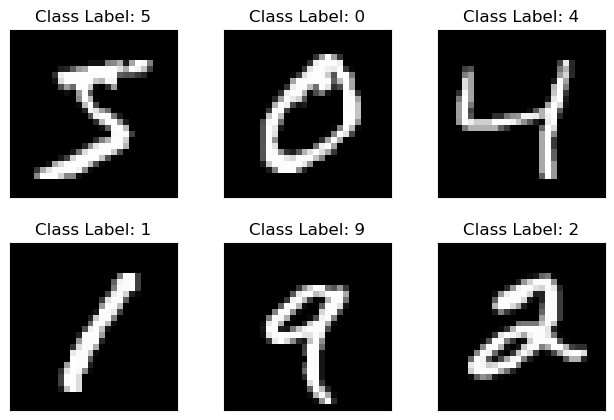

In [23]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2, 3, i+1)
  plt.tight_layout()
  plt.imshow(train_data[i][0][0], cmap='gray', interpolation='none')
  plt.title("Class Label: {}".format(train_data[i][1]))
  plt.xticks([])
  plt.yticks([])


## Function to train the model

In [24]:
def train_model(model, train_loader, device, loss_fn, optimizer, input_dim=(-1,1,28,28)):
    model.train()
    # Initiate a loss monitor
    train_loss = []
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning and not supervised classification)
    for images, labels in train_loader: # the variable `labels` will be used for customised training
        # reshape input
        images = torch.reshape(images,input_dim)
        images = images.to(device)
        labels = labels.to(device)
        # predict the class
        predicted = model(images)
        loss = loss_fn(predicted, labels)
        # Backward pass (back propagation)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()       
        wandb.log({"Training Loss": loss})
        wandb.watch(model)
        train_loss.append(loss.detach().cpu().numpy())
    return np.mean(train_loss)

## Function to test the model

In [25]:
# Testing Function
def test_model(model, test_loader, device, loss_fn, input_dim=(-1,1,28,28)):
    # Set evaluation mode for encoder and decoder
    model.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        predicted = []
        actual = []
        for images, labels in test_loader:
            # reshape input
            images = torch.reshape(images,input_dim)
            images = images.to(device)
            labels = labels.to(device)
            ## predict the label
            pred = model(images)
            # Append the network output and the original image to the lists
            predicted.append(pred.cpu())
            actual.append(labels.cpu())
        # Create a single tensor with all the values in the lists
        predicted = torch.cat(predicted)
        actual = torch.cat(actual) 
        # Evaluate global loss
        val_loss = loss_fn(predicted, actual)
    return val_loss.data

Before we start training let's delete the huge FC-Net we built and build a reasonable FC-Net (You learnt why such larger networks are not reasonable in the previous notebook)

In [26]:
# del fc_net, fc_net_custom1, fc_net_custom2, fc_net_custom3
torch.cuda.empty_cache()
# Building a reasonable fully connected network
fc_net = build_custom_fc_net(inp_dim=(1,28,28), out_dim=10, hidden_fc_dim=[128,64,32])

<b>Exercise 3.1.5:</b> 
Code the `weight_init_xavier` function by referring to https://pytorch.org/docs/stable/nn.init.html. Replace the weight initializations to your own function.


In [33]:
### Set the random seed for reproducible results
torch.manual_seed(0)
# Choosing a device based on the env and torch setup
# device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

def weight_init_zero(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        torch.nn.init.constant_(m.weight, 0.0)
        m.bias.data.fill_(0.01)

def weight_init_xavier(m):
    '''
    TO-DO: please add code below to add xavier uniform initialization and remove the 'pass'
    '''
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_uniform_(m.weight, 0.0)
        m.bias.data.fill_(0.01)
    pass#xavier_uniform_
    
    
fc_net.to(device)
conv_net.to(device)

# Apply the weight initialization
fc_net.apply(weight_init_zero)
conv_net.apply(weight_init_zero)

# Apply the xavier weight initialization
#TO-DO: Add your function here
fc_net.apply(weight_init_xavier)
conv_net.apply(weight_init_xavier)


# Take the parameters for optimiser
params_to_optimize_fc = [
    {'params': fc_net.parameters()}
]

params_to_optimize_conv = [
    {'params': conv_net.parameters()}
]
### Define the loss function
loss_fn = torch.nn.NLLLoss()
### Define an optimizer (both for the encoder and the decoder!)
lr= 0.001

optim_fc = torch.optim.Adam(params_to_optimize_fc, lr=lr, weight_decay=1e-05)
optim_conv = torch.optim.Adam(params_to_optimize_conv, lr=lr, weight_decay=1e-05)
num_epochs = 30
wandb.config = {
  "learning_rate": lr,
  "epochs": num_epochs,
  "batch_size": batch_size
}

Selected device: mps


# Training the Convolutional Neural Networks

In [35]:
print('Conv Net training started')
history_conv = {'train_loss':[],'val_loss':[]}
start_time = datetime.datetime.now()

for epoch in range(num_epochs):
    ### Training 
    
    train_loss = train_model(
        model=conv_net,
        train_loader=train_loader,
        device=device,
        loss_fn=loss_fn,
        optimizer=optim_conv,
        input_dim=(-1,1,28,28))
    ### Validation  (use the testing function)
    val_loss = test_model(
        model=conv_net,
        test_loader=test_loader,
        device=device,
        loss_fn=loss_fn,
        input_dim=(-1,1,28,28))
    # Print Losses 
    print(f'Epoch {epoch+1}/{num_epochs} : train loss {train_loss:.3f} \t val loss {val_loss:.3f}')
    history_conv['train_loss'].append(train_loss)
    history_conv['val_loss'].append(val_loss)
    
    
print(f'Conv Net training done in {(datetime.datetime.now()-start_time).total_seconds():.3f} seconds!')

Conv Net training started


/Users/karan_mudaliar/miniconda3/lib/python3.11/site-packages/torch/nn/modules/module.py:1519: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1/30 : train loss 1.869 	 val loss 1.856
Epoch 2/30 : train loss 1.828 	 val loss 1.823
Epoch 3/30 : train loss 1.807 	 val loss 1.801
Epoch 4/30 : train loss 1.788 	 val loss 1.787
Epoch 5/30 : train loss 1.770 	 val loss 1.772
Epoch 6/30 : train loss 1.760 	 val loss 1.763
Epoch 7/30 : train loss 1.749 	 val loss 1.762
Epoch 8/30 : train loss 1.741 	 val loss 1.753
Epoch 9/30 : train loss 1.733 	 val loss 1.740
Epoch 10/30 : train loss 1.726 	 val loss 1.731
Epoch 11/30 : train loss 1.715 	 val loss 1.731
Epoch 12/30 : train loss 1.711 	 val loss 1.725
Epoch 13/30 : train loss 1.705 	 val loss 1.726
Epoch 14/30 : train loss 1.703 	 val loss 1.722
Epoch 15/30 : train loss 1.699 	 val loss 1.714
Epoch 16/30 : train loss 1.692 	 val loss 1.699
Epoch 17/30 : train loss 1.691 	 val loss 1.704
Epoch 18/30 : train loss 1.682 	 val loss 1.698
Epoch 19/30 : train loss 1.685 	 val loss 1.696
Epoch 20/30 : train loss 1.677 	 val loss 1.685
Epoch 21/30 : train loss 1.670 	 val loss 1.696
E

### Visualizing Training Progress of Conv Net (Also check out your wandb.ai homepage)

Text(0, 0.5, 'Negative Log Likelihood Loss')

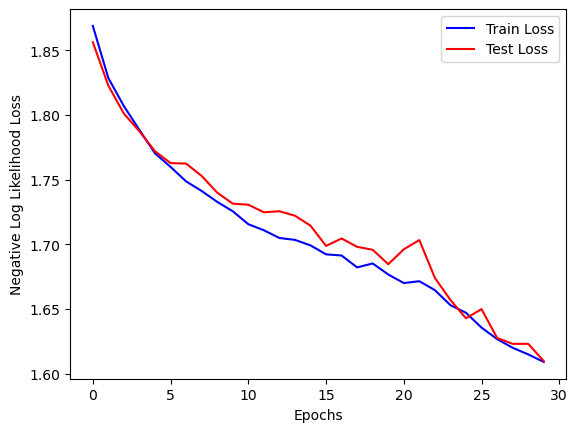

In [54]:
fig = plt.figure()
plt.plot(history_conv['train_loss'], color='blue')
plt.plot(history_conv['val_loss'], color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Negative Log Likelihood Loss')

### Visualizing Predictions of Conv Net

/var/folders/dn/jhd9djgd393gp0dk2lz40m2c0000gp/T/ipykernel_98502/539838738.py:10: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


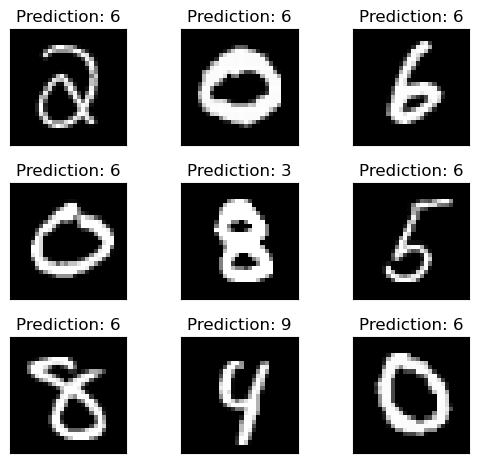

In [37]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
with torch.no_grad():
    example_data = example_data.to(device)
    output = conv_net(example_data)
example_data = example_data.cpu().detach().numpy()
fig = plt.figure(figsize=(5,5))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray',interpolation='none')
    plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
    plt.xticks([])
    plt.yticks([])

# Training the Fully-Connected Neural Networks

<b>Exercise 3.1.6:</b> Train the fully connected neural network and analyse it

In [42]:
#TO-DO:Train the fc_net here
print('FC Net training started')
history_fc = {'train_loss':[],'val_loss':[]}
start_time = datetime.datetime.now()

for epoch in range(num_epochs):
    ### Training 
    
    train_loss = train_model(
        model=fc_net,
        train_loader=train_loader,
        device=device,
        loss_fn=loss_fn,
        optimizer=optim_fc,
        input_dim=(-1,1,28,28))
    ### Validation  (use the testing function)
    val_loss = test_model(
        model=fc_net,
        test_loader=test_loader,
        device=device,
        loss_fn=loss_fn,
        input_dim=(-1,1,28,28))
    # Print Losses 
    print(f'Epoch {epoch+1}/{num_epochs} : train loss {train_loss:.3f} \t val loss {val_loss:.3f}')
    history_fc['train_loss'].append(train_loss)
    history_fc['val_loss'].append(val_loss)
    
    
print(f'FC Net training done in {(datetime.datetime.now()-start_time).total_seconds():.3f} seconds!')

FC Net training started
Epoch 1/30 : train loss 2.112 	 val loss 1.972
Epoch 2/30 : train loss 1.953 	 val loss 1.915
Epoch 3/30 : train loss 1.907 	 val loss 1.892
Epoch 4/30 : train loss 1.878 	 val loss 1.882
Epoch 5/30 : train loss 1.857 	 val loss 1.840
Epoch 6/30 : train loss 1.842 	 val loss 1.827
Epoch 7/30 : train loss 1.828 	 val loss 1.823
Epoch 8/30 : train loss 1.815 	 val loss 1.808
Epoch 9/30 : train loss 1.801 	 val loss 1.801
Epoch 10/30 : train loss 1.793 	 val loss 1.782
Epoch 11/30 : train loss 1.774 	 val loss 1.767
Epoch 12/30 : train loss 1.759 	 val loss 1.755
Epoch 13/30 : train loss 1.753 	 val loss 1.765
Epoch 14/30 : train loss 1.725 	 val loss 1.731
Epoch 15/30 : train loss 1.715 	 val loss 1.723
Epoch 16/30 : train loss 1.697 	 val loss 1.707
Epoch 17/30 : train loss 1.693 	 val loss 1.696
Epoch 18/30 : train loss 1.680 	 val loss 1.698
Epoch 19/30 : train loss 1.671 	 val loss 1.678
Epoch 20/30 : train loss 1.660 	 val loss 1.680
Epoch 21/30 : train loss 

## Visualizing Training Progress of FC Net (Check out your wandb.ai project webpage)

Text(0, 0.5, 'Negative Log Likelihood Loss')

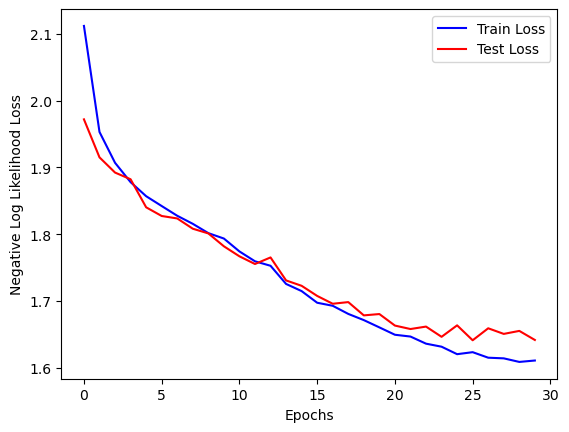

In [43]:
# TODO - Visualize the training progress of fc_net
fig = plt.figure()
plt.plot(history_fc['train_loss'], color='blue')
plt.plot(history_fc['val_loss'], color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Negative Log Likelihood Loss')

## Visualizing Predictions of FC Net

/var/folders/dn/jhd9djgd393gp0dk2lz40m2c0000gp/T/ipykernel_98502/3257089314.py:11: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


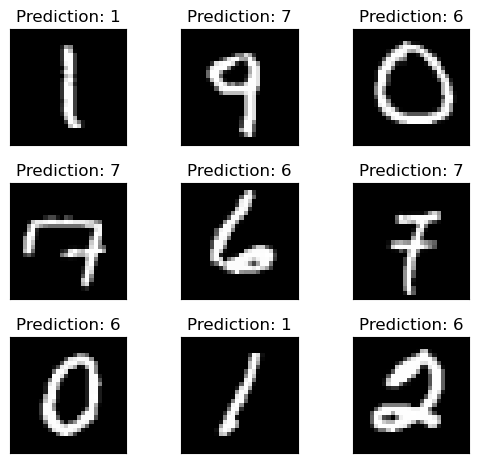

In [44]:
# TODO - Visualise the predictions of fc_net
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
with torch.no_grad():
    example_data = example_data.to(device)
    output = fc_net(example_data)
example_data = example_data.cpu().detach().numpy()
fig = plt.figure(figsize=(5,5))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray',interpolation='none')
    plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
    plt.xticks([])
    plt.yticks([])

<b>Exercise 3.1.7</b>: What are the training times for each of the model? Did both the models take similar times? If yes, why? Shouldn't CNN train faster given it's number of weights to train?

In [ ]:
#Please type your answer here ...
#Conv Net training done in 974.284 seconds!
#FC Net training done in 615.777 seconds!
'''
Its because of few reasons
Convolutional operations are computationally expensive. Even though there's parameter sharing, the actual number of operations might be high.
Convolution has many more sublayers as compared to fully connected layers. Though they will act as one layer, batch norm, conv and relu are all different.
There is also more parallization in fully connected networks than convolution
'''

## Let's see how the models perform under translation

In principle, one of the advantages of convolutions is that they are equivariant under translation which means that a function composed out of convolutions should invariant under translation.

<b>Exercise 3.1.8</b>: In practice, however, we might not see perfect invariance under translation.  What aspect of our network leads to imperfect invariance?

Type your answer here

- Convolutional layers inherently exhibit equivariance to translation, but the ConvNet we made might not guarantee perfect translation invariance. This is due to the use of strides in convolutional layers, which can result in information loss. ConvNet's relatively shallow architecture might not capture translation invariance as effectively as deeper models.
- Our ConvNet doesn't utilize pooling layers, but if it did, they could introduce some level of translation invariance

We will next measure the sensitivity  of the convolutional network to translation in practice, and we will compare it to the fully-connected version. 

In [45]:
## function to check accuracies for unit translation
def shiftVsAccuracy(model, test_loader, device, loss_fn, shifts = 12, input_dim=(-1,1,28,28)):
    # Set evaluation mode for encoder and decoder
    accuracies = []
    shifted = []
    for i in range(-shifts,shifts):
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad(): # No need to track the gradients
            # Define the lists to store the outputs for each batch
            predicted = []
            actual = []
            for images, labels in test_loader:
                # reshape input
                images = torch.roll(images,shifts=i, dims=2)
                if i == 0:
                    pass
                elif i > 0:
                    images[:,:,:i,:] = 0
                else:
                    images[:,:,i:,:] = 0
                images = torch.reshape(images,input_dim)
                images = images.to(device)
                labels = labels.to(device)
                ## predict the label
                pred = model(images)
                # Append the network output and the original image to the lists
                _ , pred = torch.max(pred.data, 1)
                total += labels.size(0)
                correct += (pred == labels).sum().item()
                predicted.append(pred.cpu())
                actual.append(labels.cpu())  
            shifted.append(images[0][0].cpu())
            acc = 100 * correct // total
            accuracies.append(acc)
    return accuracies,shifted

In [46]:
accuracies,shifted = shiftVsAccuracy(
        model=conv_net,
        test_loader=test_loader,
        device=device,
        shifts=12,
        loss_fn=loss_fn,
        input_dim=(-1,1,28,28))

Text(0.5, 1.0, 'Accuracy Vs Translation')

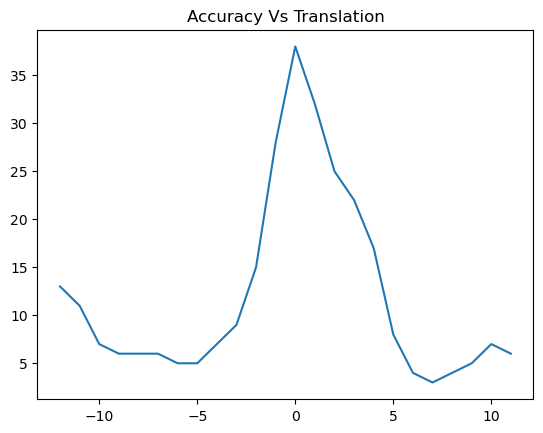

In [47]:
shifts = np.arange(-12,12)
plt.plot(shifts,accuracies)
plt.title('Accuracy Vs Translation')

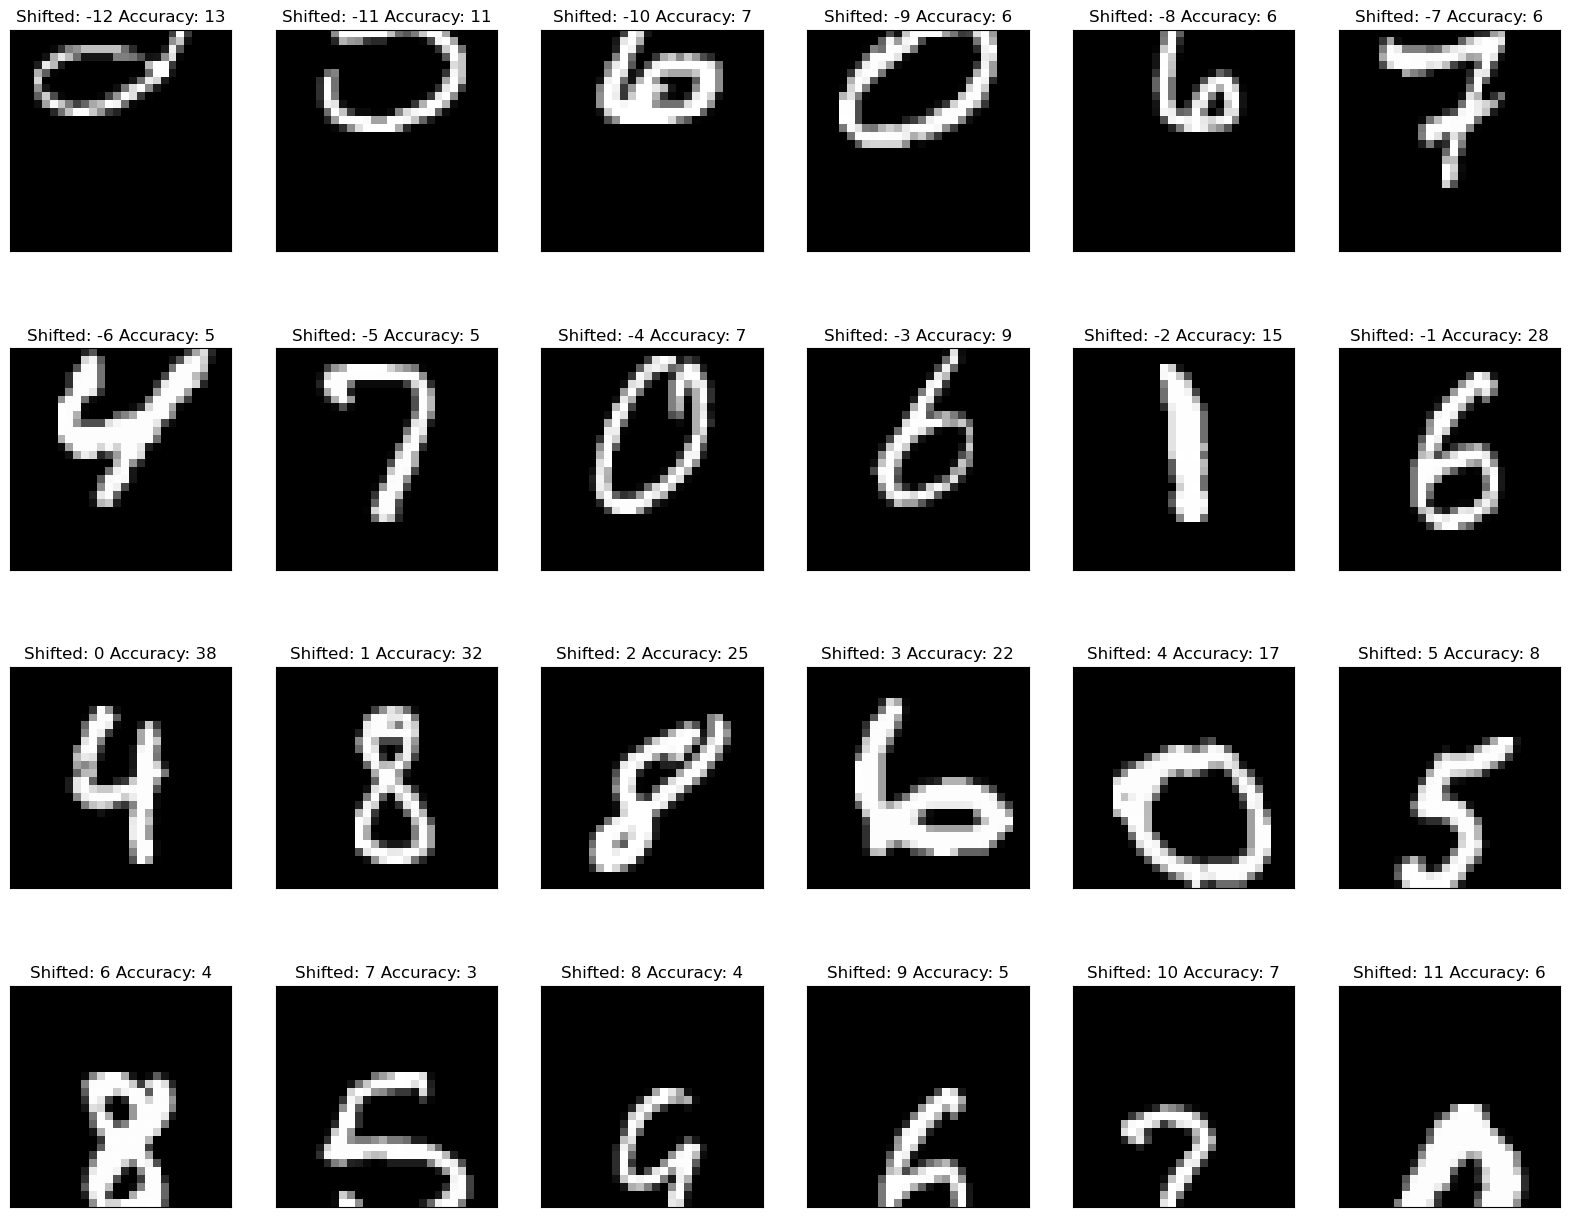

In [48]:
fig = plt.figure(figsize=(20,20))
plt_num = 0
for i in range(-12,12):
    plt.subplot(5,6,plt_num+1)
    plt.imshow(shifted[plt_num], cmap='gray',interpolation='none')
    plt.title(f"Shifted: {i} Accuracy: {accuracies[plt_num]}")
    plt.xticks([])
    plt.yticks([])
    plt_num+=1

<b>Exercise 3.1.8:</b>
Do the same for FC-Net and plot the accuracies. Is the rate of accuracy degradation same as Conv-Net? Can you justify why this happened? <br>
Clue: You might want to look at the way convolution layers process information

In [50]:
# To-DO Write your code below
accuracies,shifted = shiftVsAccuracy(
        model=fc_net,
        test_loader=test_loader,
        device=device,
        shifts=12,
        loss_fn=loss_fn,
        input_dim=(-1,1,28,28))

/Users/karan_mudaliar/miniconda3/lib/python3.11/site-packages/torch/nn/modules/module.py:1519: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Text(0.5, 1.0, 'Accuracy Vs Translation')

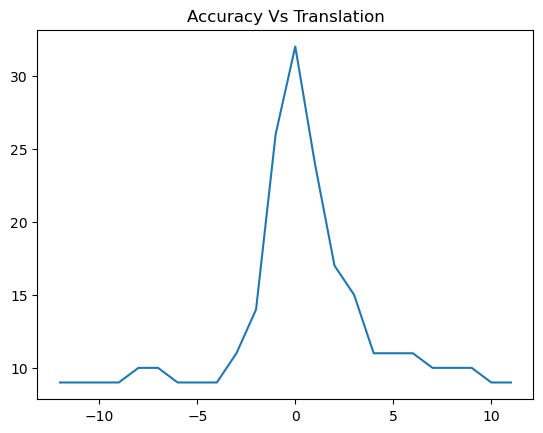

In [51]:
shifts = np.arange(-12,12)
plt.plot(shifts,accuracies)
plt.title('Accuracy Vs Translation')

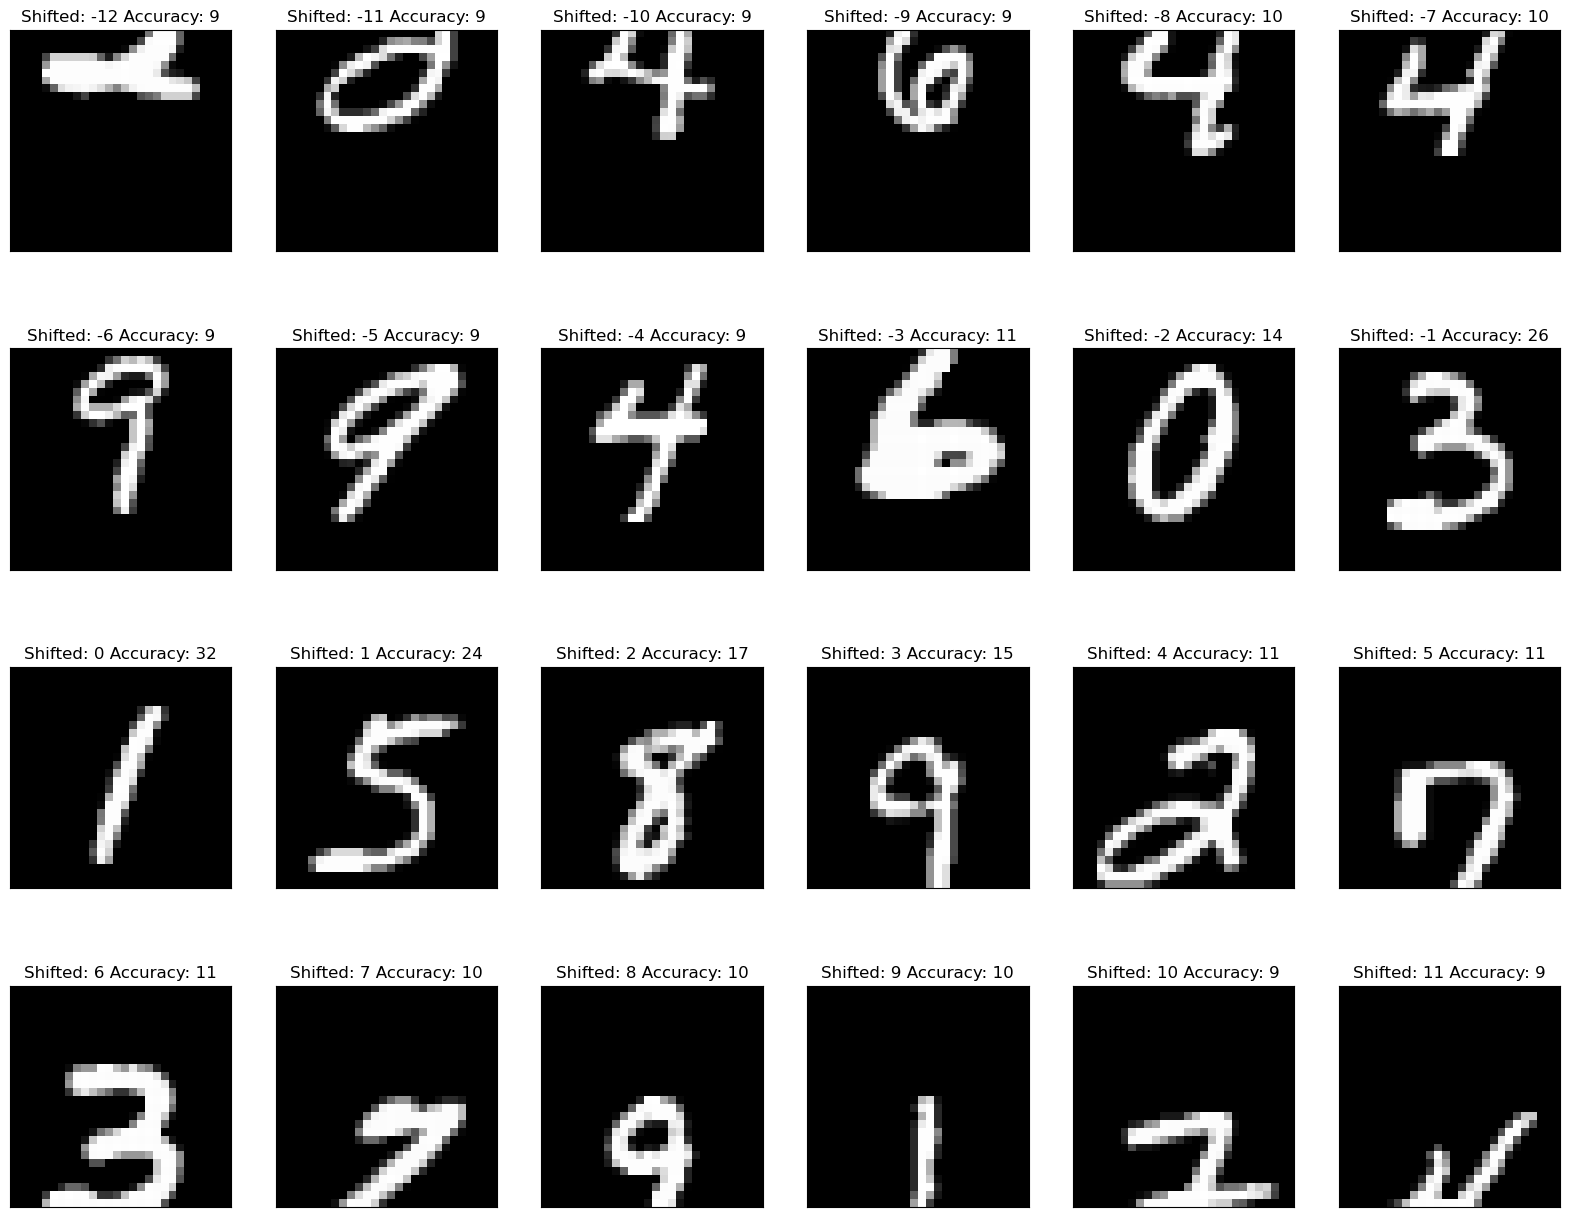

In [53]:
fig = plt.figure(figsize=(20,20))
plt_num = 0
for i in range(-12,12):
    plt.subplot(5,6,plt_num+1)
    plt.imshow(shifted[plt_num], cmap='gray',interpolation='none')
    plt.title(f"Shifted: {i} Accuracy: {accuracies[plt_num]}")
    plt.xticks([])
    plt.yticks([])
    plt_num+=1